In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import json
import pandas as pd

### Load dataset

In [ ]:
with open("/content/gdrive/My Drive/NLP/Project/SQUAD MATERIAL/training_set.json") as dataset_file:
  dataset_json = json.load(dataset_file)

In [ ]:
dataset_paragraph = []
dataset_question = []
dataset_answer = []
titles = []
for data in dataset_json["data"]:
  for paragraph in data["paragraphs"]:
    for qa in paragraph["qas"]:
      question = qa["question"]
      for answer in qa["answers"]:
        #answer = (answer["answer_start"], answer["answer_start"]+len(answer["text"]))
        dataset_paragraph.append(paragraph["context"])
        dataset_question.append(question)
        dataset_answer.append(answer["text"])

In [ ]:
QUANTITY = None

### Pre-processing

#### Normalization and tagging

In [ ]:
import en_core_web_sm
tag_preprocessor = en_core_web_sm.load()

def preprocess_tags(text):
  doc = tag_preprocessor(text)
  return [ (t.text, t.tag_, t.ent_type_, t.like_num, t.is_stop) for t in doc ]

def normalize(token):
  text, pos, entity, is_num, is_stop = token
  text = text.lower()
  return (text, pos, entity, is_num, is_stop)

def preprocess(dataset):
  return [[normalize(token) for token in preprocess_tags(text)] for text in dataset]

norm_dataset_paragraph = preprocess(dataset_paragraph[:QUANTITY])
norm_dataset_question = preprocess(dataset_question[:QUANTITY])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


KeyboardInterrupt: ignored

#### Glove embedding

In [ ]:
import gensim
import gensim.downloader as gloader

def load_glove(embedding_dimension=50):
  return gloader.load(f'glove-wiki-gigaword-{embedding_dimension}')

embedding_dimension = 100
embedding_model = load_glove(embedding_dimension)

#### Inspect vocabulary

In [ ]:
def oov_check(model, vocabulary):
  return [word for word in vocabulary if word not in model.vocab]

def build_vocabulary(*dataset):
  vocabulary = set([token for ds in dataset for text in ds for token in text ])
  return list(vocabulary)

vocabulary = build_vocabulary([ [ t[0] for t in p ] for p in norm_dataset_paragraph ], [ [ t[0] for t in p ] for p in norm_dataset_question ])
oov_words = oov_check(embedding_model, vocabulary)

print(f'Vocabulary Length: {len(vocabulary)}')
print(f'OOV words: {len(oov_words)/len(vocabulary):.2%}')
#a lot of OOV words, mainly typos and some numbers (+_)(~9,19%)

def inspect_compound_words_or_number(oov_word, separators):
  compound_words = set()
  for sep in separators:
    compound_words_tmp = set()
    for oov_word in oov_words:
      if sep in oov_word:
        present = True
        for word in oov_word.split(sep):
          if word not in embedding_model:
            present = False
            break
        if present:
          compound_words_tmp.add(oov_word)
    percentage = len(compound_words_tmp)/len(oov_words)
    print(f"The percentage of the OOV words that can be build as mean of the token unified by the character '{sep}' is {percentage:.3%}")
    compound_words = compound_words.union(compound_words_tmp)
  return set(oov_words).difference(compound_words)

actual_oov = inspect_compound_words_or_number(oov_words, '-.,\\/\'[]()')
print(f"OOV words left: {len(actual_oov)/len(vocabulary):.2%}")

#### Tokenizer

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(tokenizer, pos_tag_to_idx, ner_to_idx, dataset):
  result = []
  for paragraph in dataset:
    result_paragraph = []
    for text, pos, ent, is_num, is_stop in paragraph:
      token = tokenizer.texts_to_sequences([text])[0]
      if text != ' ' and len(token):
        result_paragraph.append((token[0], pos_tag_to_idx[pos], ner_to_idx[ent], is_num, is_stop))
    result.append(result_paragraph)
  return result

token_set = set([
  *[t[0] for question in norm_dataset_question for t in question ],
  *[t[0] for paragraph in norm_dataset_paragraph for t in paragraph ]
])
tokenizer = Tokenizer(oov_token='<oov_token>', char_level=False, filters='')
tokenizer.fit_on_texts(token_set)
word_to_idx = tokenizer.word_index
vocab_size = len(word_to_idx) + 1

NameError: ignored

In [ ]:
pos_tag_set = set(sorted([ token[1] for sentence in (norm_dataset_question + norm_dataset_paragraph) for token in sentence ]))
pos_tag_to_idx = {t:i+1 for i,t in enumerate(pos_tag_set)}
ner_set = set(sorted([ token[2] for sentence in (norm_dataset_question + norm_dataset_paragraph) for token in sentence ]))
ner_to_idx = {t: i + 1 for i, t in enumerate(ner_set)}

tok_dataset_question = tokenize(tokenizer, pos_tag_to_idx, ner_to_idx, norm_dataset_question)
tok_dataset_paragraph = tokenize(tokenizer, pos_tag_to_idx, ner_to_idx, norm_dataset_paragraph)
tok_dataset_answer = tokenizer.texts_to_sequences(dataset_answer)

In [ ]:
!pip install pickle5
import pickle5 as pickle
with open('/content/gdrive/My Drive/NLP/Project/models/tf_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Embedding matrix

In [ ]:
replacements = {
  'n\'t': 'not',
  '\'re': 'are',
  '\'ve': 'have',
  '\'ll': 'will',
  '\'d': 'would',
  '\'m': 'am'
}

def compute_embedding_matrix(model, word_to_idx):
  matrix = np.ndarray(shape=(len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
  matrix[0] = np.zeros(embedding_dimension)
  for word, idx in word_to_idx.items():
    word = replacements.get(word, word)
    if word in model:
      matrix[idx] = model[word]
    else:  
      matrix[idx] = np.random.uniform(low=-4.0, high=4.0, size=(embedding_dimension))
  return matrix

embedding_matrix = compute_embedding_matrix(embedding_model, word_to_idx)

### Prepare dataset

#### Load pre-processed dataset

In [ ]:
tok_dataset = pd.read_json("/content/gdrive/My Drive/NLP/Project/SQUAD MATERIAL/tok_dataframe_with_titles.json")
tok_dataset_paragraph = tok_dataset["paragraph"].values.tolist()
tok_dataset_question = tok_dataset["question"].values.tolist()
tok_dataset_answer = tok_dataset["answer"].values.tolist()
tok_dataset_titles = tok_dataset["titles"].values.tolist()
embedding_matrix = np.load("/content/gdrive/My Drive/NLP/Project/SQUAD MATERIAL/embedding_matrix.npy")

#### Paragraphs inspection

In [ ]:
def getNumPargraphUntilLenght(lengths, limit):
  sum = 0
  for (k,v) in lengths.items(): 
    if k <= limit:
      sum += v
  return sum

lengths = dict()
for x in tok_dataset_paragraph:
  if len(x) in lengths:
    lengths[len(x)] += 1
  else:
    lengths[len(x)] = 1

tot_paragraphs = sum(lengths.values())
print("Number of paragraphs: ", tot_paragraphs)
for k in [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 750]:
  num = getNumPargraphUntilLenght(lengths, k)
  print("Paragraphs with length less than", k, "=", num, "(" + "{:.2f}".format(num/tot_paragraphs*100) + "%)")

Number of paragraphs:  87599
Paragraphs with length less than 200 = 76128 (86.91%)
Paragraphs with length less than 250 = 83396 (95.20%)
Paragraphs with length less than 300 = 86060 (98.24%)
Paragraphs with length less than 350 = 86979 (99.29%)
Paragraphs with length less than 400 = 87376 (99.75%)
Paragraphs with length less than 450 = 87503 (99.89%)
Paragraphs with length less than 500 = 87547 (99.94%)
Paragraphs with length less than 550 = 87570 (99.97%)
Paragraphs with length less than 600 = 87580 (99.98%)
Paragraphs with length less than 650 = 87589 (99.99%)
Paragraphs with length less than 750 = 87594 (99.99%)


##### Delete paragraphs below a certain treshold

In [ ]:
LENGTH_THRESHOLD = 400
i = 0
while i < len(tok_dataset_paragraph):
  if len(tok_dataset_paragraph[i]) > LENGTH_THRESHOLD:
    tok_dataset_paragraph.pop(i)
    tok_dataset_question.pop(i)
    tok_dataset_answer.pop(i)
  else:
    i += 1

#### Padding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def make_padding(dataset, max_len=None):
  return pad_sequences(dataset, padding='pre', value=0.0, maxlen=max_len)

pad_dataset_question = make_padding(tok_dataset_question)
pad_dataset_paragraph = make_padding(tok_dataset_paragraph)

#### Compute input and target arrays

In [ ]:
from tensorflow.keras.utils import to_categorical

NUM_OF_SAMPLES = 1000

def createTargetArray(len, index_target, blurred=False, len_blurr=15, scale_factor = 0.5):
  array = np.zeros(len, dtype=np.int32)
  prob_value = 1 
  array[index_target] = prob_value
  if blurred:
    for i in range(1, len_blurr+1):
      prob_value *= scale_factor
      if (index_target - i >= 0):
        array[index_target-i] = prob_value
      if (index_target + i < len):
        array[index_target+i] = prob_value
    array = array/np.sum(array)
  return array

X_question = []
X_paragraph = []
X_flag_present = []
Y_start = []
Y_end = []

for i, (answer, paragraph) in enumerate(zip(tok_dataset_answer, pad_dataset_paragraph)):
  #if i > NUM_OF_SAMPLES:
  #  break
  found = False
  answer_length = len(answer)

  for start in range(paragraph.shape[0] - answer_length + 1):
    end = start + answer_length

    if (np.all(paragraph[start:end, 0] == answer)):
      found = True
      
      Y_start.append(start)
      Y_end.append(end-1)
      
      X_question.append(pad_dataset_question[i])
      X_paragraph.append(pad_dataset_paragraph[i])
      break

  if found:
    X_flag_present.append([[token and token in pad_dataset_question[i,:,0]] for token in pad_dataset_paragraph[i,:,0]])

X_question = np.array(X_question)
X_paragraph = np.array(X_paragraph)
X_flag_present = np.array(X_flag_present)
question_max_len = X_question.shape[1]
paragraph_max_len = X_paragraph.shape[1]
#Reshape inputs
X_question_text = np.expand_dims(X_question[:,:,0], axis=-1)
X_question_pos = np.expand_dims(X_question[:,:,1], axis=-1)
X_question_ner = np.expand_dims(X_question[:,:,2], axis=-1)
X_question_is_num = np.expand_dims(X_question[:,:,3], axis=-1)
X_question_is_stop = np.expand_dims(X_question[:,:,4], axis=-1)
X_paragraph_text = np.expand_dims(X_paragraph[:,:,0], axis=-1)
X_paragraph_pos = np.expand_dims(X_paragraph[:,:,1], axis=-1)
X_paragraph_ner = np.expand_dims(X_paragraph[:,:,2], axis=-1)
X_paragraph_is_stop = np.expand_dims(X_paragraph[:,:,3], axis=-1)
X_paragraph_is_num = np.expand_dims(X_paragraph[:,:,4], axis=-1)
#Convert output to one hot vectors
Y_start = to_categorical(Y_start, num_classes=paragraph_max_len)
Y_end = to_categorical(Y_end, num_classes=paragraph_max_len)

#### Split datasets

In [ ]:
def split_train_validation_test(array, valid, test):
  dim = array.shape[0]
  valid_split = int(dim*valid)
  test_split = int(dim*test)
  return array[:-(valid_split+test_split)], array[-(valid_split+test_split):-test_split], array[-test_split:]

#Fraction respect to the entire dataset
valid_split = 0.1
test_split = 0.1

X_question_text_train, X_question_text_valid, X_question_text_test, = split_train_validation_test(X_question_text, valid_split, test_split)
X_question_pos_train, X_question_pos_valid, X_question_pos_test, = split_train_validation_test(X_question_pos, valid_split, test_split)
X_question_ner_train, X_question_ner_valid, X_question_ner_test, = split_train_validation_test(X_question_ner, valid_split, test_split)
X_question_is_num_train, X_question_is_num_valid, X_question_is_num_test, = split_train_validation_test(X_question_is_num, valid_split, test_split)
X_question_is_stop_train, X_question_is_stop_valid, X_question_is_stop_test, = split_train_validation_test(X_question_is_stop, valid_split, test_split)
X_paragraph_text_train, X_paragraph_text_valid, X_paragraph_text_test, = split_train_validation_test(X_paragraph_text, valid_split, test_split)
X_paragraph_pos_train, X_paragraph_pos_valid, X_paragraph_pos_test, = split_train_validation_test(X_paragraph_pos, valid_split, test_split)
X_paragraph_ner_train, X_paragraph_ner_valid, X_paragraph_ner_test, = split_train_validation_test(X_paragraph_ner, valid_split, test_split)
X_paragraph_is_stop_train, X_paragraph_is_stop_valid, X_paragraph_is_stop_test, = split_train_validation_test(X_paragraph_is_stop, valid_split, test_split)
X_paragraph_is_num_train, X_paragraph_is_num_valid, X_paragraph_is_num_test, = split_train_validation_test(X_paragraph_is_num, valid_split, test_split)
X_flag_present_train, X_flag_present_valid, X_flag_present_test, = split_train_validation_test(X_flag_present, valid_split, test_split)
Y_start_train, Y_start_valid, Y_start_test, = split_train_validation_test(Y_start, valid_split, test_split)
Y_end_train, Y_end_valid, Y_end_test, = split_train_validation_test(Y_end, valid_split, test_split)

In [ ]:
# np.save("/content/gdrive/MyDrive/NLP/Project/Test/paragraph_test", X_paragraph_text_test)
# np.save("/content/gdrive/MyDrive/NLP/Project/Test/answer_start_test", Y_start_test)
# np.save("/content/gdrive/MyDrive/NLP/Project/Test/answer_end_test", Y_end_test)

In [ ]:
#define X/Y_train, X/Y_valid, X/Y_test 
X_train = [X_question_text_train, X_question_pos_train, X_question_ner_train, X_question_is_num_train, X_question_is_stop_train,
         X_paragraph_text_train, X_paragraph_pos_train, X_paragraph_ner_train, X_paragraph_is_stop_train, X_paragraph_is_num_train, X_flag_present_train]
Y_train = [Y_start_train, Y_end_train]
X_valid = [X_question_text_valid, X_question_pos_valid, X_question_ner_valid, X_question_is_num_valid, X_question_is_stop_valid,
         X_paragraph_text_valid, X_paragraph_pos_valid, X_paragraph_ner_valid, X_paragraph_is_stop_valid, X_paragraph_is_num_valid, X_flag_present_valid]
Y_valid = [Y_start_valid, Y_end_valid]
X_test = [X_question_text_test, X_question_pos_test, X_question_ner_test, X_question_is_num_test, X_question_is_stop_test,
         X_paragraph_text_test, X_paragraph_pos_test, X_paragraph_ner_test, X_paragraph_is_stop_test, X_paragraph_is_num_test, X_flag_present_test]
Y_test = [Y_start_test, Y_end_test]

### Models

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, concatenate, Dot, Reshape, Flatten, Concatenate, Add, Average, Attention, Permute, Softmax
from tensorflow.keras.models import Model
from tensorflow import reduce_mean, reduce_sum, argmax
from tensorflow.keras.utils import plot_model

#### Custom loss function

In [ ]:
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error 
from tensorflow.math import argmax
from tensorflow import cast, float32
import tensorflow as tf

def softargmax(x, beta=1e10):
  x = tf.convert_to_tensor(x)
  x_range = tf.range(x.shape.as_list()[-1], dtype=x.dtype)
  res = tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=-1)
  tf.print(res)
  return res

def custom_loss_function(y_true, y_pred):
    #return categorical_crossentropy(y_true, y_pred) 
    return mean_squared_error(softargmax(y_true), softargmax(y_pred))

#### Baseline model (encoding + similarity)

In [ ]:
latent_space_dim = 128
vocab_size = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
question_max_len = X_question.shape[1]
paragraph_max_len = X_paragraph.shape[1]

embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dimension, weights=[embedding_matrix], mask_zero=True, trainable=False)

#Question
input_question = Input((question_max_len,), name="input_question")
embedding_question = embedding(input_question)
lstm_question = Bidirectional(LSTM(latent_space_dim, return_sequences=True))(embedding_question)
question_encoding = lstm_question
#question_encoding = Reshape((1,latent_space_dim*2))(Dense(256, activation='softmax')(Flatten()(lstm_question)))

#Paragraph
input_paragraph = Input((paragraph_max_len,), name="input_paragraph")
embedding_paragraph = embedding(input_paragraph)
input_flag = Input((paragraph_max_len, 1), name="input_flag")

#Attention
attention = Attention()([embedding_paragraph, embedding_question])
input_pos_tag = Input((paragraph_max_len, 1), name="input_pos_tag")
input_ner_tag = Input((paragraph_max_len, 1), name="input_ner_tag")
input_is_num = Input((paragraph_max_len, 1), name="input_is_num")
input_is_stop = Input((paragraph_max_len, 1), name="input_is_stop")

#Refined input
refined_input_paragraph = Concatenate(axis=-1)([attention, embedding_paragraph, input_flag, input_pos_tag, input_ner_tag, input_is_num, input_is_stop])
paragraph_encoding = Bidirectional(LSTM(latent_space_dim, return_sequences=True))(refined_input_paragraph)

#Unification
#similarity = Reshape((paragraph_max_len,))(Dot(axes=2, normalize=True)([paragraph_encoding, question_encoding]))
attentioned_encondings = Attention()([question_encoding, paragraph_encoding])

start_dense_classifier = Dense(1, activation="softmax", name="start_output")(attentioned_encondings)
#start_index_output = argmax(start_dense_classifier, axis=1)
end_dense_classifier = Dense(1, activation="softmax", name="end_output")(attentioned_encondings)
#end_index_output = argmax(end_dense_classifier, axis=1)
qa_model = Model([input_question, input_paragraph, input_flag, input_pos_tag, input_ner_tag, input_is_num, input_is_stop], 
                 [start_dense_classifier, end_dense_classifier])

qa_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
qa_model.summary()
plot_model(qa_model, show_shapes=True)

#### Encoder-Decoder model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_paragraph (InputLayer)    [(None, 400)]        0                                            
__________________________________________________________________________________________________
input_question (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             9097500     input_question[0][0]             
                                                                 input_paragraph[0][0]            
__________________________________________________________________________________________________
input_paragraph_pos_tag (InputL [(None, 400, 1)]     0                                      

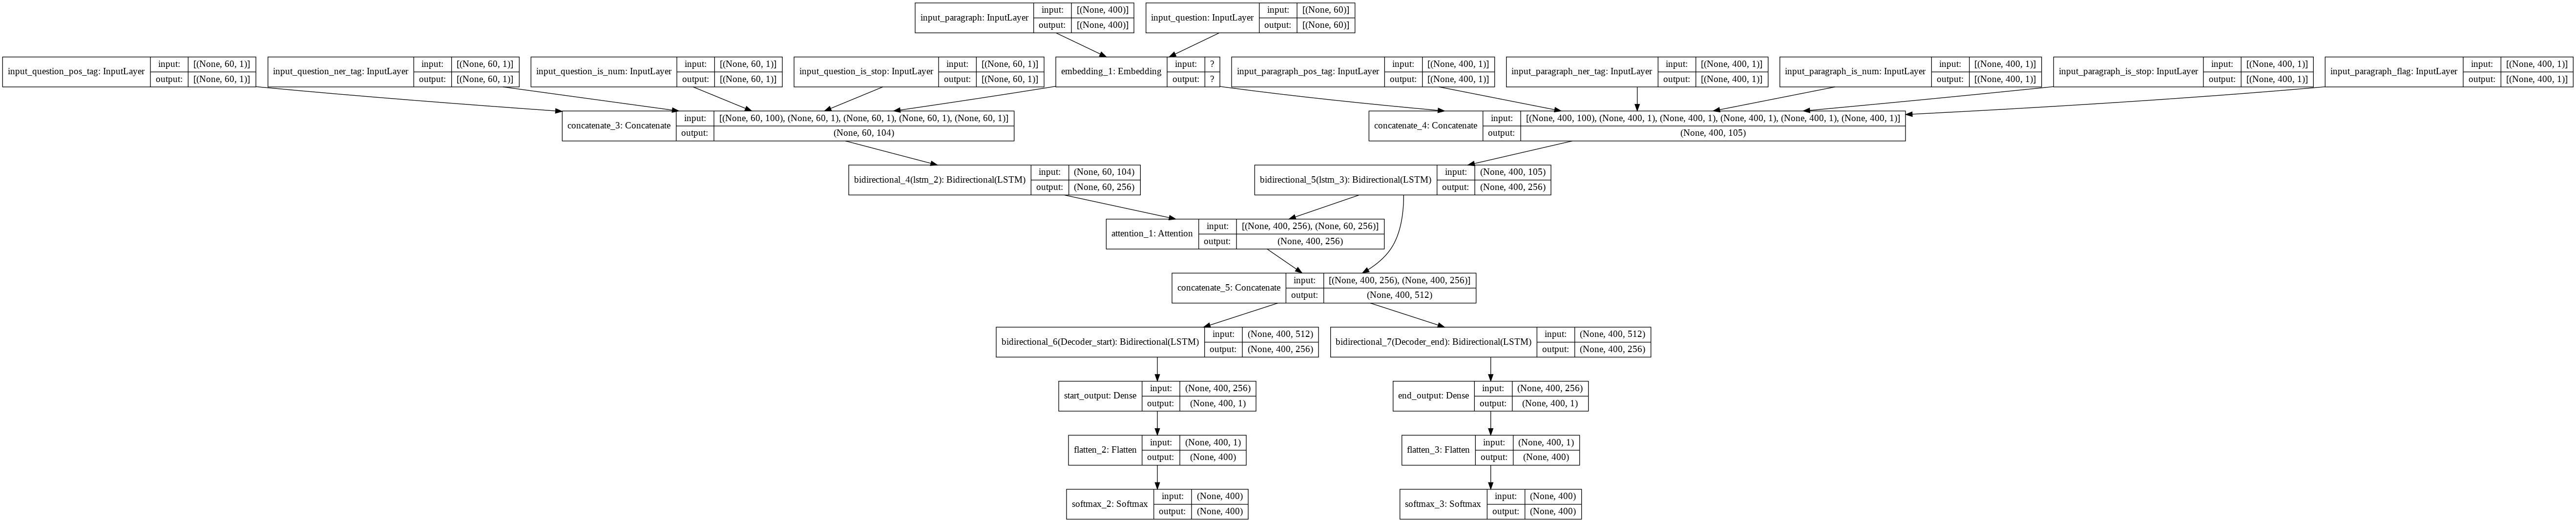

In [ ]:
latent_space_dim = 128
vocab_size = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]

embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dimension, weights=[embedding_matrix], mask_zero=True, trainable=False)

#Question
input_question = Input((question_max_len,), name="input_question")
embedding_question = embedding(input_question)
input_question_pos_tag = Input((question_max_len, 1), name="input_question_pos_tag")
input_question_ner_tag = Input((question_max_len, 1), name="input_question_ner_tag")
input_question_is_num = Input((question_max_len, 1), name="input_question_is_num")
input_question_is_stop = Input((question_max_len, 1), name="input_question_is_stop")
refined_input_question = Concatenate(axis=-1)([embedding_question, input_question_pos_tag, input_question_ner_tag, input_question_is_num, input_question_is_stop])
question_encoding = Bidirectional(LSTM(latent_space_dim, return_sequences=True, dropout=0.2))(refined_input_question)

#Paragraph
input_paragraph = Input((paragraph_max_len,), name="input_paragraph")
embedding_paragraph = embedding(input_paragraph)
input_paragraph_pos_tag = Input((paragraph_max_len, 1), name="input_paragraph_pos_tag")
input_paragraph_ner_tag = Input((paragraph_max_len, 1), name="input_paragraph_ner_tag")
input_paragraph_is_num = Input((paragraph_max_len, 1), name="input_paragraph_is_num")
input_paragraph_is_stop = Input((paragraph_max_len, 1), name="input_paragraph_is_stop")
input_paragraph_flag = Input((paragraph_max_len, 1), name="input_paragraph_flag")
refined_input_paragraph = Concatenate(axis=-1)([embedding_paragraph, input_paragraph_pos_tag, input_paragraph_ner_tag, input_paragraph_is_num, input_paragraph_is_stop, input_paragraph_flag])
paragraph_encoding = Bidirectional(LSTM(latent_space_dim, return_sequences=True, dropout=0.2))(refined_input_paragraph)

encoder_attention = Attention(dropout=0)([paragraph_encoding, question_encoding])
encoder_output = Concatenate()([paragraph_encoding, encoder_attention])

#Decoder
decoder_start_output = Bidirectional(LSTM(latent_space_dim, return_sequences=True, dropout=0.2, name="Decoder_start"))(encoder_output)
decoder_end_output = Bidirectional(LSTM(latent_space_dim, return_sequences=True, dropout=0.2, name="Decoder_end"))(encoder_output)

#Classifiers
start_output = Softmax()(Flatten()(Dense(1, name="start_output")(decoder_start_output)))
end_output = Softmax()(Flatten()(Dense(1, name="end_output")(decoder_end_output)))

qa_model = Model([input_question, input_question_pos_tag, input_question_ner_tag, input_question_is_num, input_question_is_stop, 
                  input_paragraph, input_paragraph_pos_tag, input_paragraph_ner_tag, input_paragraph_is_num, input_paragraph_is_stop, input_paragraph_flag], 
                 [start_output, end_output])

qa_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
qa_model.summary()
plot_model(qa_model, show_shapes=True)

#### Fit

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "/content/gdrive/MyDrive/NLP/Project/logs/"

In [ ]:
qa_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=2, batch_size=128)

Epoch 1/2
454/454 [==============================] - 7604s 17s/step - loss: 5.1200 - softmax_4_loss: 2.7214 - softmax_5_loss: 2.3986 - softmax_4_categorical_accuracy: 0.3296 - softmax_5_categorical_accuracy: 0.3816 - val_loss: 5.0219 - val_softmax_4_loss: 2.6878 - val_softmax_5_loss: 2.3342 - val_softmax_4_categorical_accuracy: 0.3557 - val_softmax_5_categorical_accuracy: 0.4005
Epoch 2/2
454/454 [==============================] - 7552s 17s/step - loss: 4.6194 - softmax_4_loss: 2.4675 - softmax_5_loss: 2.1519 - softmax_4_categorical_accuracy: 0.3800 - softmax_5_categorical_accuracy: 0.4339 - val_loss: 4.7182 - val_softmax_4_loss: 2.5370 - val_softmax_5_loss: 2.1812 - val_softmax_4_categorical_accuracy: 0.3777 - val_softmax_5_categorical_accuracy: 0.4355


In [ ]:
qa_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=2, batch_size=128)

Epoch 1/2
454/454 [==============================] - 2179s 5s/step - loss: 4.3389 - softmax_4_loss: 2.3244 - softmax_5_loss: 2.0145 - softmax_4_softmax_4_categorical_accuracy: 0.4092 - softmax_5_softmax_5_categorical_accuracy: 0.4658 - val_loss: 4.5349 - val_softmax_4_loss: 2.4441 - val_softmax_5_loss: 2.0908 - val_softmax_4_softmax_4_categorical_accuracy: 0.3940 - val_softmax_5_softmax_5_categorical_accuracy: 0.4509
Epoch 2/2
454/454 [==============================] - 2113s 5s/step - loss: 4.1299 - softmax_4_loss: 2.2179 - softmax_5_loss: 1.9121 - softmax_4_softmax_4_categorical_accuracy: 0.4310 - softmax_5_softmax_5_categorical_accuracy: 0.4891 - val_loss: 4.4383 - val_softmax_4_loss: 2.3987 - val_softmax_5_loss: 2.0397 - val_softmax_4_softmax_4_categorical_accuracy: 0.4021 - val_softmax_5_softmax_5_categorical_accuracy: 0.4599


In [ ]:
qa_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=2, batch_size=128)

Epoch 1/2
454/454 [==============================] - 2302s 5s/step - loss: 3.9561 - softmax_4_loss: 2.1259 - softmax_5_loss: 1.8302 - softmax_4_softmax_4_softmax_4_categorical_accuracy: 0.4478 - softmax_5_softmax_5_softmax_5_categorical_accuracy: 0.5067 - val_loss: 4.3776 - val_softmax_4_loss: 2.3597 - val_softmax_5_loss: 2.0178 - val_softmax_4_softmax_4_softmax_4_categorical_accuracy: 0.4074 - val_softmax_5_softmax_5_softmax_5_categorical_accuracy: 0.4680
Epoch 2/2
454/454 [==============================] - 2290s 5s/step - loss: 3.8187 - softmax_4_loss: 2.0537 - softmax_5_loss: 1.7650 - softmax_4_softmax_4_softmax_4_categorical_accuracy: 0.4646 - softmax_5_softmax_5_softmax_5_categorical_accuracy: 0.5230 - val_loss: 4.3086 - val_softmax_4_loss: 2.3107 - val_softmax_5_loss: 1.9980 - val_softmax_4_softmax_4_softmax_4_categorical_accuracy: 0.4202 - val_softmax_5_softmax_5_softmax_5_categorical_accuracy: 0.4745


#### Load trained models

In [ ]:
qa_model.save("/content/gdrive/My Drive/NLP/Project/EncoderDecoder_epochs=7_latentspace=128_batchsize=128_valid=0,1.h5")

In [ ]:
from tensorflow.keras.models import load_model
qa_model = load_model("/content/gdrive/My Drive/NLP/Project/EncoderDecoder_epochs=7_latentspace=128_batchsize=128_valid=0,1.h5")

In [ ]:
Y_pred = qa_model.predict(X_test)
np.save("/content/gdrive/MyDrive/NLP/Project/Test/start_test", Y_pred[0])
np.save("/content/gdrive/MyDrive/NLP/Project/Test/end_test", Y_pred[1])

In [ ]:
start = np.argmax(np.load("/content/gdrive/MyDrive/NLP/Project/Test/start_test.npy"),axis=-1)
end = np.argmax(np.load("/content/gdrive/MyDrive/NLP/Project/Test/end_test.npy"),axis=-1)

In [ ]:
print(start[0])
print(end[0])

361
365
